In [151]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.utils.weight_norm as weight_norm
import torch.nn as nn
from sklearn.metrics import mean_squared_error , mean_absolute_error #平均均方误差/平均绝对误差
import math
import time
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F

In [152]:
# 定义dataset
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [153]:
class WindDataset:
    def __init__(self,predict_step=3,label=1):
        self.raw_data = np.array(pd.read_excel("weather.xlsx")).astype(float)
        # 数据标准化
        self.predict_step = predict_step
        self.label = label
        self.min = np.amin(self.raw_data)
        self.max = np.amax(self.raw_data)
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.65,val_por=0.2,test_por=0.15, window_size=50):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        len_train = int(self.data.shape[0] * train_por)
        #print("len_train",len_train)
        len_val = int(self.data.shape[0] * val_por)
        len_test = int(self.data.shape[0] * test_por)
        train_seqs = self.data[:len_train,:]
        print(train_seqs.shape)
        val_seqs = self.data[len_train:len_val+len_train,:]
        print(val_seqs.shape)
        test_seqs = self.data[len_train+len_val:len_val+len_train+len_test,:]
        print(test_seqs.shape)

        for i in range(train_seqs.shape[0] - window_size-self.predict_step+1):
            train_seq = train_seqs[i:i+window_size+self.predict_step]
            train_x.append(train_seq[0:window_size,:])
            train_y.append(train_seq[window_size:window_size+self.predict_step,self.label])

        for i in range(val_seqs.shape[0] - window_size-self.predict_step+1):
            val_seq = val_seqs[i:i+window_size+self.predict_step]
            val_x.append(val_seq[0:window_size,:])
            val_y.append(val_seq[window_size:window_size+self.predict_step,self.label])

        for i in range(test_seqs.shape[0] - window_size-self.predict_step+1):
            test_seq = test_seqs[i:i+window_size+self.predict_step]
            test_x.append(test_seq[0:window_size,:])
            test_y.append(test_seq[window_size:window_size+self.predict_step,self.label])

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y).squeeze())
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y).squeeze())
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y).squeeze())
        return train_set, val_set, test_set

In [154]:
WindData = WindDataset()
train_set, val_set, test_set = WindData.construct_set()
batch_size = 16
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

(347, 14)
(106, 14)
(80, 14)


In [155]:
class Chomp1d(nn.Module):
    def __init__(self,chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = int(chomp_size)
    def forward(self,x):
        #print(self.chomp_size)
        return x[:,:,0:-self.chomp_size].contiguous()
#在padding与chomp浪费了大量时间为了使输出序列相等
class TCNResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,kernelsize,dilation):
        super(TCNResidualBlock,self).__init__()
        self.ke = int(kernelsize+(kernelsize-1)*(dilation-1))
        self.conv = nn.Sequential(
            weight_norm(nn.Conv1d(inchannel,outchannel,kernel_size=kernelsize,dilation=dilation,padding=self.ke-1)),
            Chomp1d(self.ke-1),    
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            weight_norm(nn.Conv1d(outchannel,outchannel,kernel_size=kernelsize,dilation=dilation,padding=self.ke-1)),
            Chomp1d(self.ke-1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        self.conv1x1 = nn.Sequential( 
            weight_norm(nn.Conv1d(inchannel,outchannel,kernel_size=1)),
            )
        
    def forward(self,X):
        Y = self.conv(X)
        #print("Y:",Y.shape)
        X = self.conv1x1(X)
        #print("X:",X.shape)
        out = F.relu(X+Y)
        return out

In [156]:
#通道数是特征的意思
#input: batch_size * features * seq_length但数据集的输入是batch_size * seq_length * features
block1 = TCNResidualBlock(14,32,5,1)
block2 = TCNResidualBlock(32,16,5,2)
block3 = TCNResidualBlock(16,8,3,4)

class TCNet(nn.Module):
    def __init__(self,hidden_size,predict_step):
        super(TCNet,self).__init__()
        self.features = nn.Sequential(
            block1,block2,block3
        )
        self.flatten = nn.Flatten()
        self.regression = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, predict_step),
            nn.LeakyReLU()
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
    def forward(self,X):
        X = X.permute(0,2,1).contiguous()
        features = self.features(X)
        #print("features:",features.shape)
        out = self.flatten(features)
        #out = F.avg_pool1d(features,features.shape[-1])
        #print("out:",out.shape)
        out = self.regression(out).squeeze()
        return out

In [157]:
device = torch.device("cuda")
input_size = train_set.X.shape[-1]
hidden_size = 400
output_size = 3
lr = 0.001
epochs = 80
loss = nn.MSELoss()
my_tcn = TCNet(hidden_size,output_size).to(device)
optimizer = torch.optim.Adam(my_tcn.parameters(), lr)

In [158]:
def mean_absolute_percentage_error(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mean_squared_error(y, pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y, pred)
    mape = mean_absolute_percentage_error(y, pred)
    return [rmse, mae, mape]

In [159]:
def evaluate(net,data_iter, loss, denormalize_fn, device='cuda:0'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long())
        y = denormalize_fn(y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += l.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count

In [160]:
def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,device='cuda:0'):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []
    for epoch in range(num_epoch):
        net.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            #print("X:",X.shape)
            #print("Y:",Y.shape)
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            y_hat = net(X).squeeze()
            #print("y_hat",y_hat.shape)
            #print("y_hat:",y_hat)
            #print("Y:",Y)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1

            batch_time.append(time.time() - batch_s)

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = evaluate(net, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())
        print('*** epoch%d, train loss %.8f, train rmse %.4f, val loss %.8f, val rmse %.6f, time use %.3fs' %(epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')

    # 计算测试集效果
    test_score, test_loss = evaluate(net,test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst

In [161]:
def visualization(train_loss,val_loss):
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show() 

In [162]:
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst = train(my_tcn, train_loader, val_loader, test_loader,loss, WindData.denormalize, optimizer, epochs,device=device)

*** epoch1, train loss 0.00435706, train rmse 24.1701, val loss 0.00004200, val rmse 21.177394, time use 0.327s
*** epoch2, train loss 0.00385412, train rmse 23.2686, val loss 0.00002232, val rmse 20.323615, time use 0.282s
*** epoch3, train loss 0.00348809, train rmse 22.1154, val loss 0.00000621, val rmse 19.820899, time use 0.281s
*** epoch4, train loss 0.00279445, train rmse 19.7320, val loss 0.00058841, val rmse 14.725512, time use 0.298s
*** epoch5, train loss 0.00141097, train rmse 13.9407, val loss 0.00177188, val rmse 4.921652, time use 0.330s
*** epoch6, train loss 0.00072832, train rmse 9.9501, val loss 0.00150002, val rmse 5.369026, time use 0.278s
*** epoch7, train loss 0.00071240, train rmse 9.8317, val loss 0.00178949, val rmse 5.014480, time use 0.313s
*** epoch8, train loss 0.00050721, train rmse 8.3088, val loss 0.00177714, val rmse 4.780987, time use 0.273s
*** epoch9, train loss 0.00053739, train rmse 8.5085, val loss 0.00233160, val rmse 3.550231, time use 0.248s
*

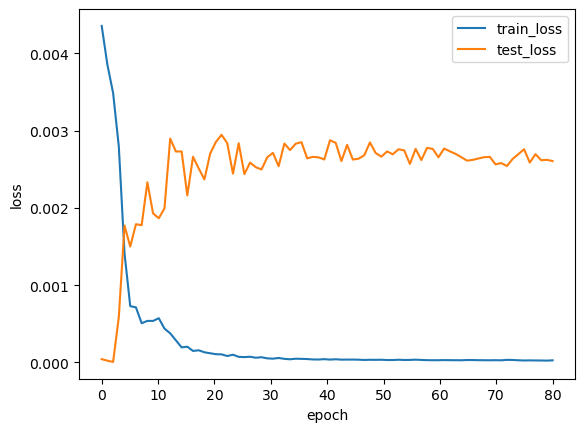

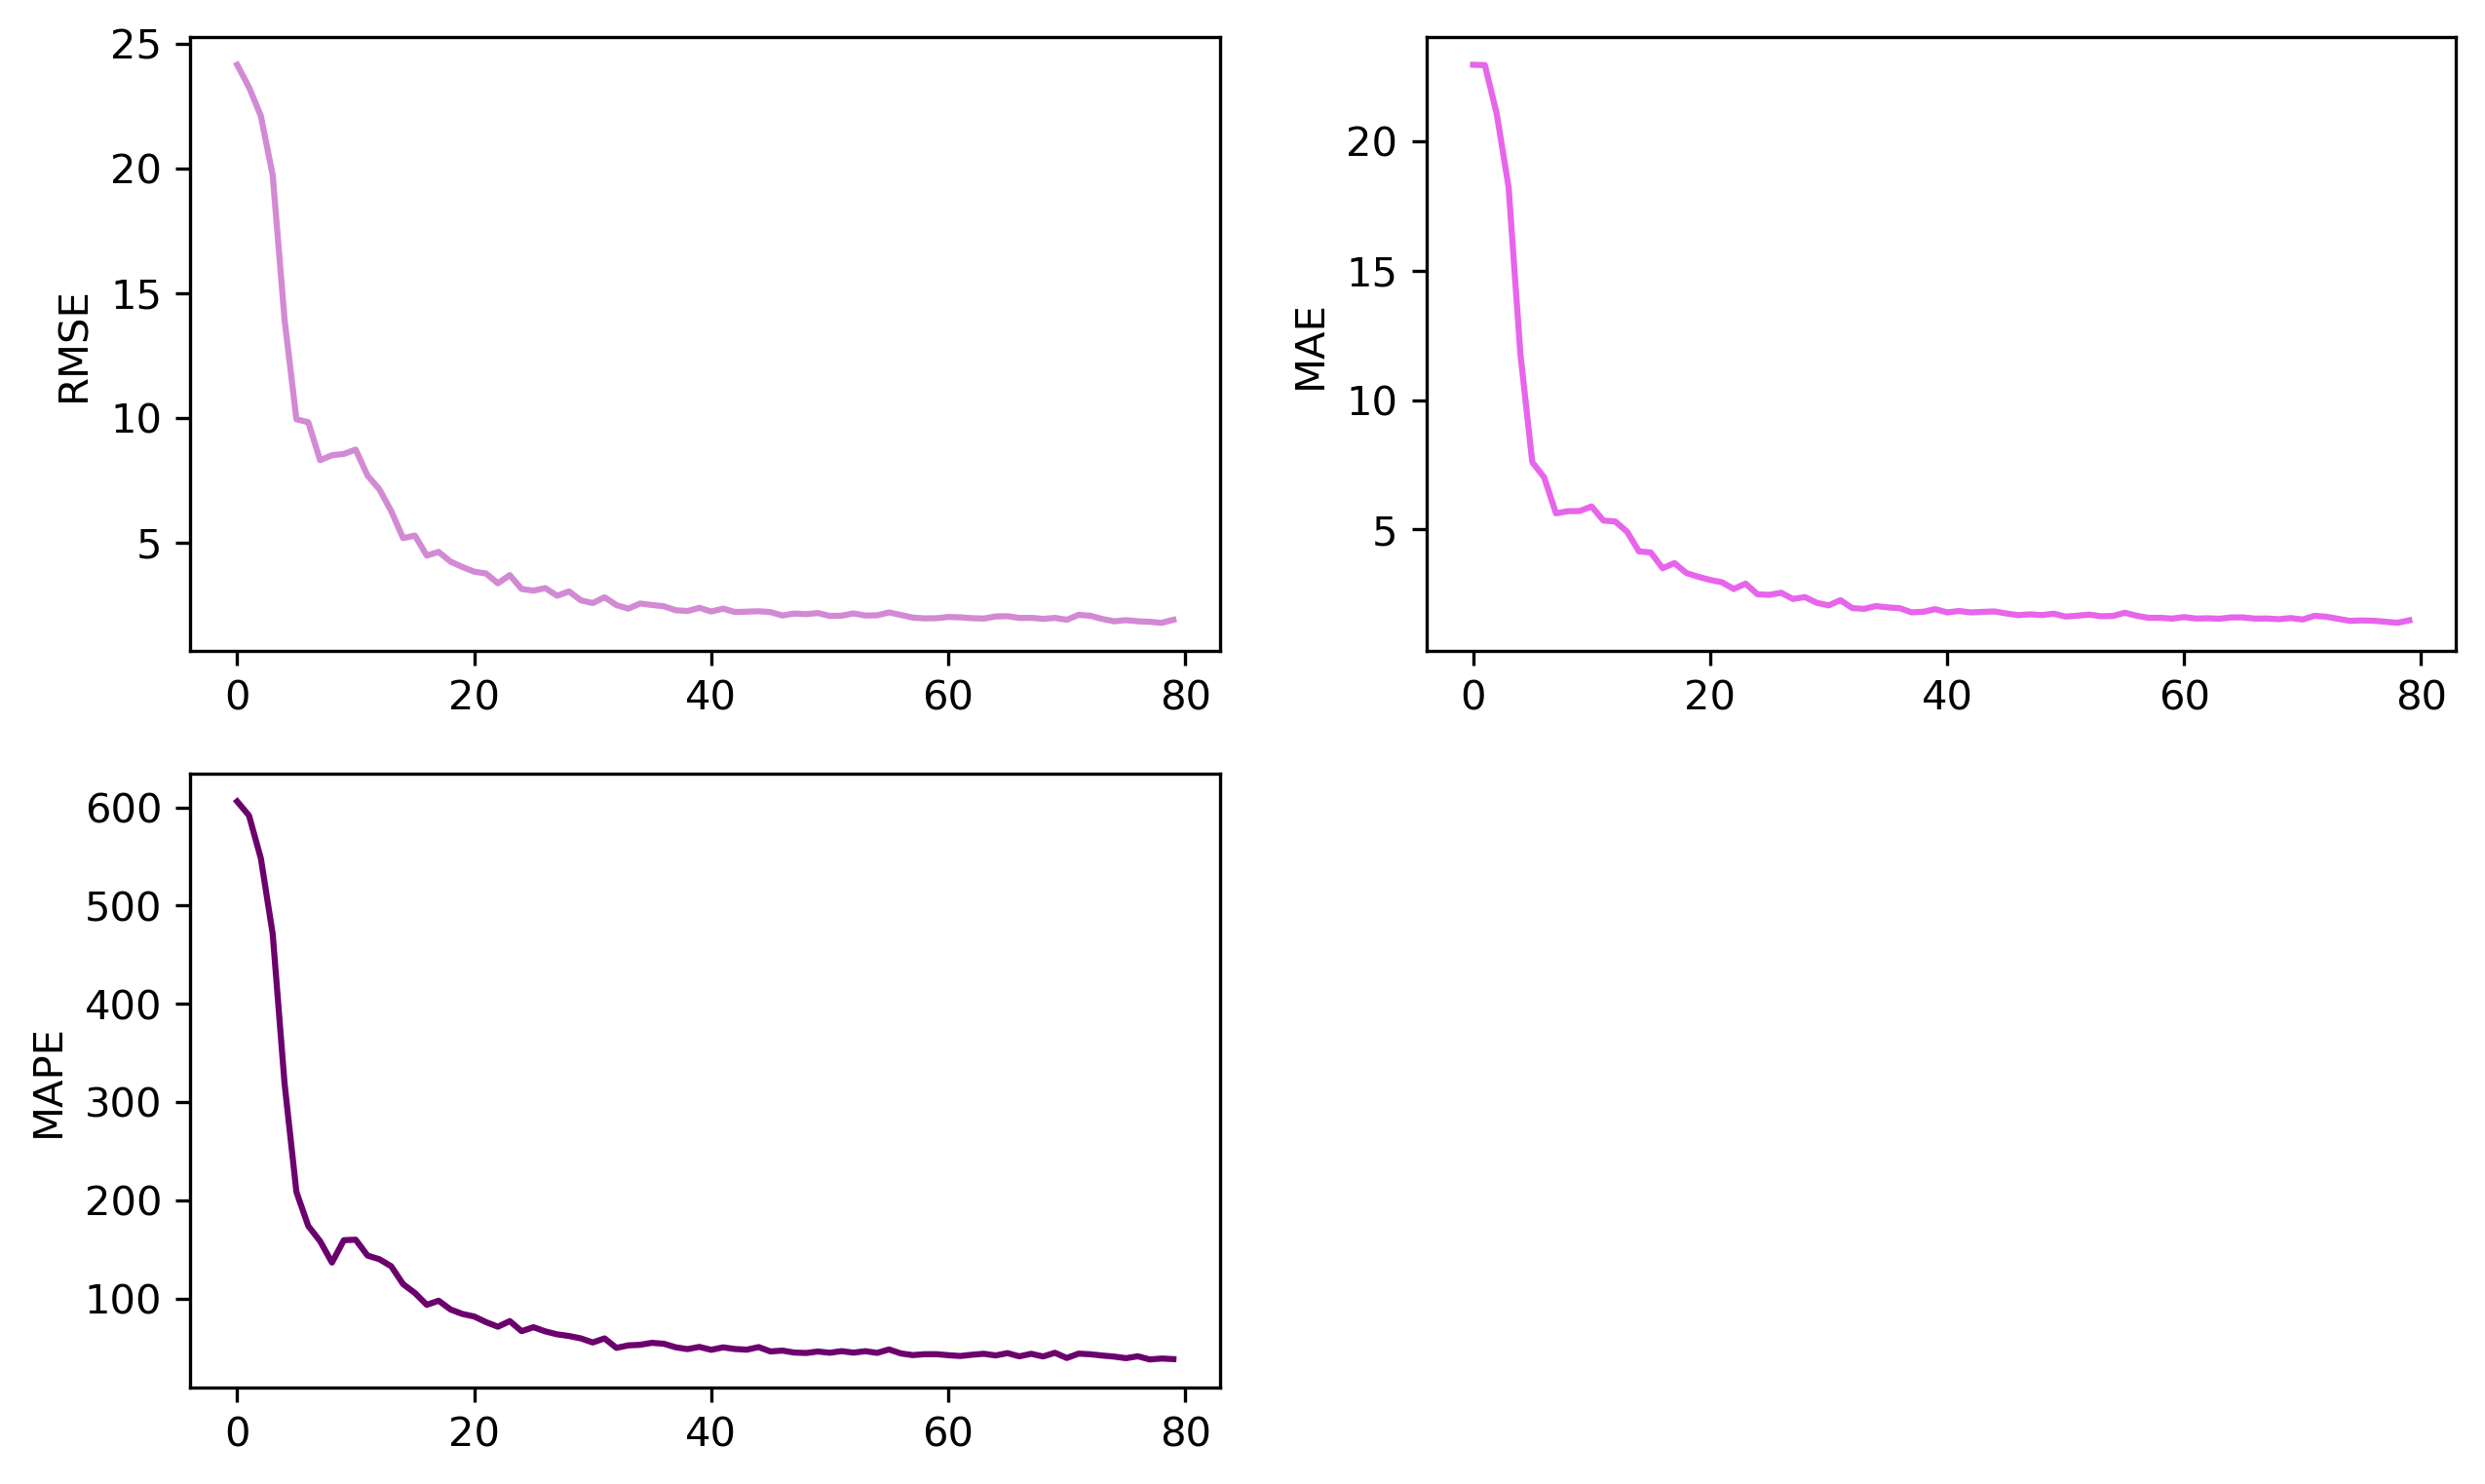

In [163]:
#RMSE和样本有关，RMSE大表示预测值和理论值的差值也大
visualization(train_loss_lst, val_loss_lst)
plot_metric(train_score_lst)

In [164]:
train_loader = Data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=4, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=4, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4, drop_last=True)

y_predict: (295, 3)
y_true: (295, 3)
x1: (295,)


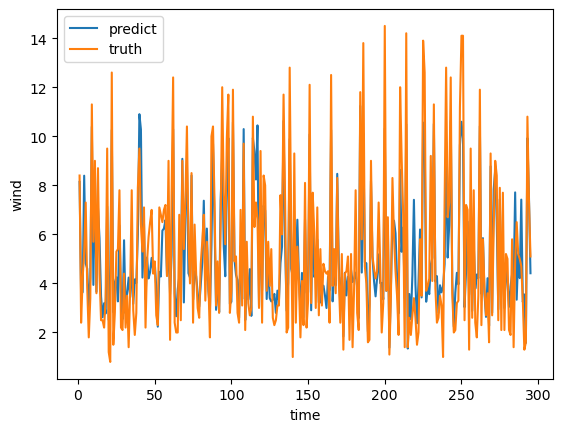

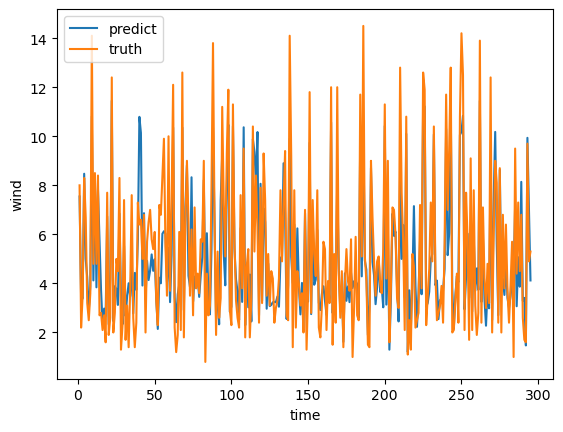

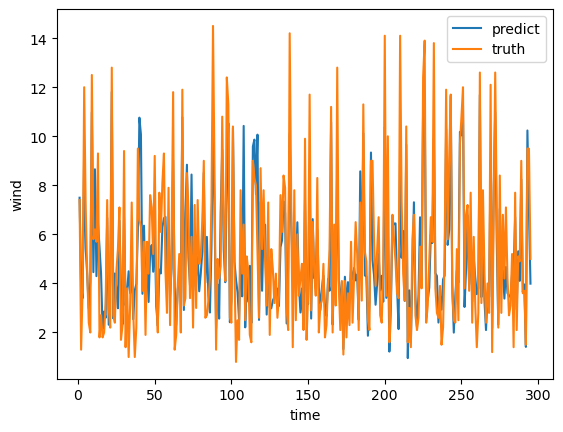

In [165]:
def time_series_visualize(net,test_iter,denormalize_fn,num_epoch):
    net.eval()
    y_predict = []
    y_true = []
    for epoch in range(num_epoch):
        for x,y in test_iter:
            y_hat = net(x.to(device)).squeeze()
            y_hat = denormalize_fn(y_hat).detach().cpu().numpy()
            y = denormalize_fn(y)
            y_true.append(y.detach().numpy())
            y_predict.append(y_hat)
    y_predict = np.array(y_predict).squeeze()# epoch batch feature 28X3
    print("y_predict:",y_predict.shape)
    y_true = np.array(y_true).squeeze() # 28X3
    print("y_true:",y_true.shape)
    x1 = np.linspace(1,y_predict.shape[0],y_predict.shape[0])
    print("x1:",x1.shape)
    for j in range(y_predict.shape[-1]):    
        plt.plot(x1,y_predict[:,j],label='predict')
        plt.plot(x1,y_true[:,j],label='truth')
        plt.xlabel("time")
        plt.ylabel("wind")
        plt.legend()
        plt.show()
time_series_visualize(my_tcn,train_loader,WindData.denormalize,1)

y_predict: (54, 3)
y_true: (54, 3)
x1: (54,)


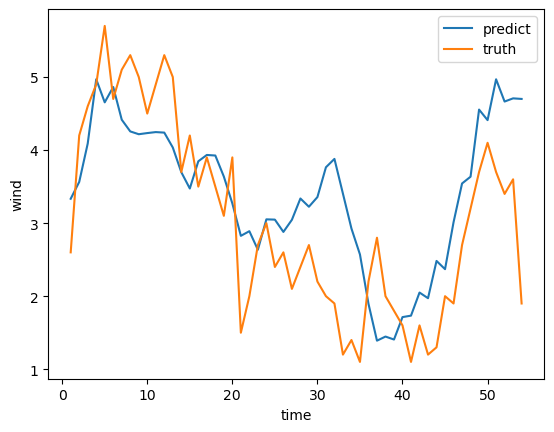

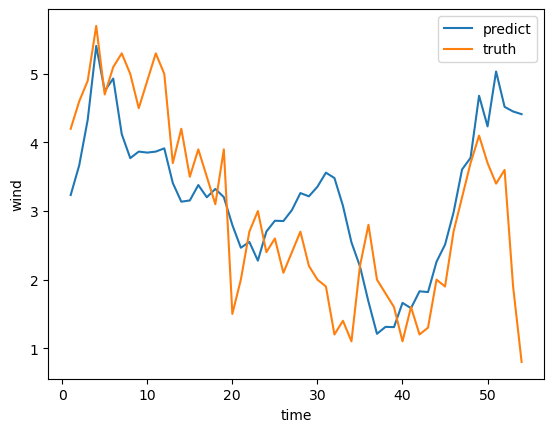

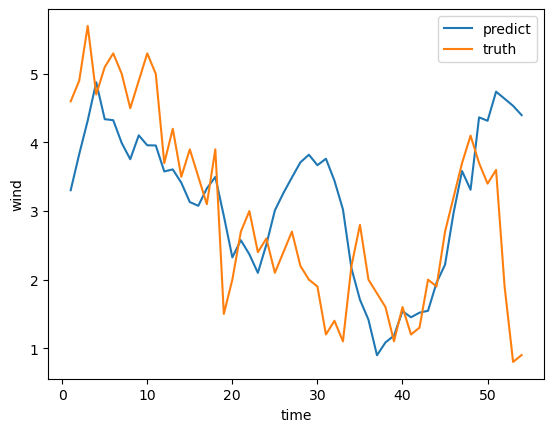

In [166]:
time_series_visualize(my_tcn,val_loader,WindData.denormalize,1)

y_predict: (28, 3)
y_true: (28, 3)
x1: (28,)


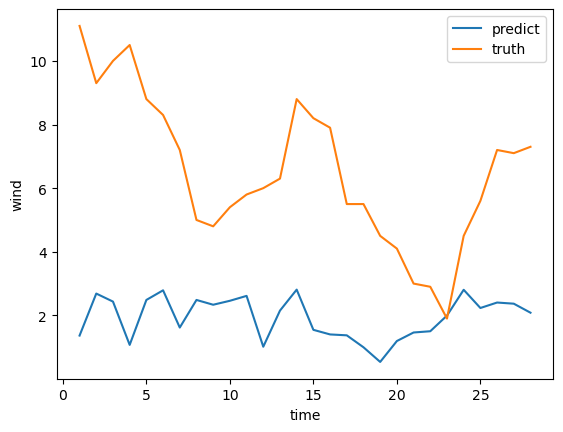

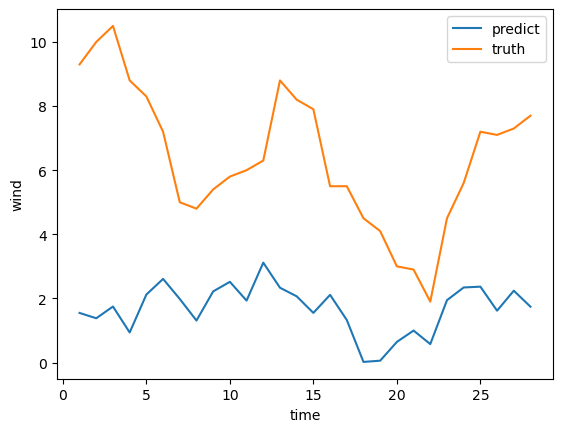

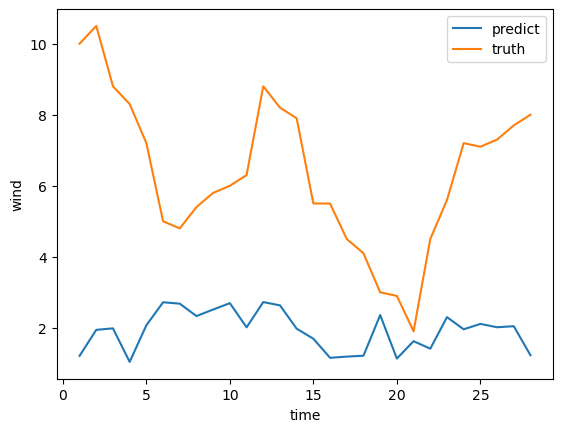

In [167]:
time_series_visualize(my_tcn,test_loader,WindData.denormalize,1)